In [13]:
from typing import Annotated
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from typing_extensions import TypedDict
from langchain_core.messages import BaseMessage
from langgraph.graph import StateGraph,START,END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

In [14]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [15]:
# Set your OpenAI API key
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")
os.environ["LANGSMITH_API_KEY"] = os.getenv("LANGCHAIN_API_KEY")
os.environ["LANGSMITH_TRACING"] ="true"

# Initialize models
llm = ChatOpenAI(model="gpt-4.1", temperature=0)
embeddings = OpenAIEmbeddings()

In [16]:
class State(TypedDict):
    messages: Annotated[list[BaseMessage],add_messages]#reducer

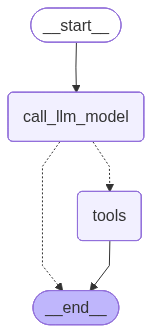

In [18]:
from langchain_core.tools import tool

@tool
def add(a:float,b:float)->float:
    """Add two numbers together"""
    return a+b

tool_node=ToolNode(tools=[add])
llm_with_tools=llm.bind_tools([add])


def call_llm_model(state:State)->State:
    response=llm_with_tools.invoke(state["messages"])
    return {"messages":response}

#Graph
builder=StateGraph(State)
builder.add_node("call_llm_model",call_llm_model)
builder.add_node("tools",tool_node)

builder.add_edge(START,"call_llm_model")

builder.add_conditional_edges(
    "call_llm_model",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools",END)

graph=builder.compile()

from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [20]:
res=graph.invoke({"messages":"What is the resent ai news?"})
print(res)
res=graph.invoke({"messages":"What is 2+9 ?"})
print(res)


{'messages': [HumanMessage(content='What is the resent ai news?', additional_kwargs={}, response_metadata={}, id='08877a9f-94cf-47f7-8637-581aec64996c'), AIMessage(content='Here are some of the most recent AI news highlights as of June 2024:\n\n1. OpenAI’s GPT-4o Release: OpenAI recently launched GPT-4o, a new flagship model that offers faster, more efficient, and more conversational AI capabilities, including real-time voice and vision features.\n\n2. Google’s Gemini Advancements: Google has expanded its Gemini AI model, integrating it into more products like Google Search, Workspace, and Android, and introducing new features such as AI-powered summaries and image generation.\n\n3. AI Regulation Developments: The European Union’s AI Act, the world’s first comprehensive AI law, is moving toward implementation, setting new standards for transparency, safety, and ethical use of AI.\n\n4. Apple’s AI Announcements: Apple is expected to unveil new AI features at its upcoming WWDC 2024 event